In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
# get the data of eurusd for given range
start_date = '2005-01-01'
end_date = '2024-05-01'

eur_usd_data_daily = yf.download('EURUSD=X', start=start_date, end=end_date)
eur_usd_data_monthly = yf.download('EURUSD=X', start=start_date, end=end_date, interval='1mo')

GSPC_data_monthly = yf.download('^GSPC', start='2004-12-01', end=end_date, interval='1mo')
STOXX50E_data_monthly = pd.read_csv('csv_files/STOXX50E.csv')

eur_usd_pct_change = eur_usd_data_daily['Close'].pct_change()

eur_usd_data_monthly.head(5)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-01,1.356594,1.362695,1.293193,1.305193,1.305193,0
2005-02-01,1.305006,1.328004,1.273707,1.321702,1.321702,0
2005-03-01,1.321895,1.347909,1.286107,1.296697,1.296697,0
2005-04-01,1.296798,1.311699,1.277906,1.292307,1.292307,0
2005-05-01,1.292307,1.298701,1.229997,1.230800,1.230800,0


In [3]:
# create a new dataframe to store the monthly data, indexes should be at the format: "2005-01"
feature_set = pd.DataFrame(index=eur_usd_data_daily.resample('M').mean().index.strftime('%Y-%m'), columns=['volatility'])

# calculate the volatility for each month
for month in feature_set.index:
    start_date = month
    end_date = pd.to_datetime(start_date) + pd.DateOffset(months=1)
    feature_set.loc[month] = round((eur_usd_pct_change.loc[start_date:end_date].std()) * (len(eur_usd_pct_change.loc[start_date:end_date]) ** (1/2)) * 100, 3)

feature_set['volatility'] = feature_set['volatility'].astype(float) 
# print the monthly data
feature_set.head(10)

,volatility
Date,
2005-01,2.668
2005-02,2.477
2005-03,2.774
2005-04,2.162
2005-05,2.793
2005-06,3.202
2005-07,2.991
2005-08,2.640
2005-09,2.284


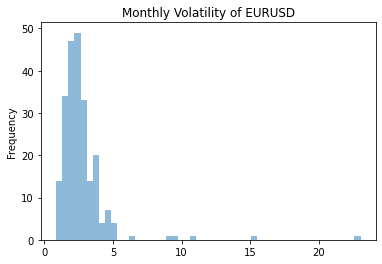

Mean: 2.735749999999999
Standard Deviation: 2.0091483641957972
Number of months that have volatility smaller than 3: 172


In [4]:
# make a histogram of the monthly volatility
feature_set['volatility'].plot.hist(bins=50, alpha=0.5, title='Monthly Volatility of EURUSD')
plt.show()

# mean and standard deviation of the monthly volatility
mean = feature_set.volatility.mean()
std = feature_set.volatility.std()
print('Mean:', mean)
print('Standard Deviation:', std)

# print the ncount of the rows that are smaller than the mean + 1 std
threshold = 3
print(f'Number of months that have volatility smaller than {threshold}:', len(feature_set[feature_set.volatility < threshold]))

In [5]:
# add a low/high column that labels the month as low or high volatility according to the threshold
feature_set['low/high'] = np.where(feature_set.volatility < threshold, 0, 1)
feature_set['low/high'] = feature_set['low/high'].shift(-1)

# print the monthly data with the low/high column
feature_set.head(10)

,volatility,low/high
Date,,
2005-01,2.668,0.0
2005-02,2.477,0.0
2005-03,2.774,0.0
2005-04,2.162,0.0
2005-05,2.793,1.0
2005-06,3.202,0.0
2005-07,2.991,0.0
2005-08,2.640,0.0
2005-09,2.284,0.0


In [6]:
# adding related features to the monthly data

# add the percentage change of the previous month
feature_set['abs_pct_change_monthly'] = abs(np.array(eur_usd_data_monthly['Close'].pct_change()))

# add max_abs_return_daily
current_month = eur_usd_data_daily.index[0].strftime('%Y-%m')
prices = []
pct_dict = {}

for idx, daily in eur_usd_data_daily.iterrows():
    if current_month != idx.strftime('%Y-%m'):
        pct_dict[current_month] = max(abs(pd.Series(prices).pct_change().max()), abs(pd.Series(prices).pct_change().min()))
        prices = []
        current_month = idx.strftime('%Y-%m')
    else:
        prices.append(daily["Close"])

feature_set['max_abs_return_daily'] = feature_set.index.map(pct_dict)

# add the fedfunds.csv file
fed_funds = pd.read_csv('csv_files/FEDFUNDS.csv')
feature_set['fed_funds'] = np.array(fed_funds[fed_funds["DATE"] > "2004-11-31"]['FEDFUNDS'])[1:]

# add the 10 year treasury rate
ten_year_treasury = pd.read_csv('csv_files/GS10.csv')
feature_set['10_year_treasury'] = np.array(ten_year_treasury[ten_year_treasury["DATE"] > "2004-11-10"]['GS10'])[1:]

# add ecb interest rate
ecb_interest = pd.read_csv('csv_files/ECBRATES.csv', header=None)
feature_set['ecb_interest'] = np.array(ecb_interest[ecb_interest[0] > "2004-12-31"][1])

# add the interest rate difference between ecb and fed
feature_set['interest_diff'] = feature_set['ecb_interest'] - feature_set['fed_funds']

# add the monthly return of the S&P 500
feature_set['sp500_return'] = np.array(GSPC_data_monthly['Close'].pct_change())[1:]

# add the monthly return of the STOXX 50
feature_set['stoxx50_return'] = np.array(STOXX50E_data_monthly[STOXX50E_data_monthly["DATE"] > "2004-11-31"]['VALUES'].pct_change())[1:]

# add the difference between the S&P 500 and STOXX 50 returns
feature_set['sp500_stoxx50_diff'] = feature_set['sp500_return'] - feature_set['stoxx50_return']

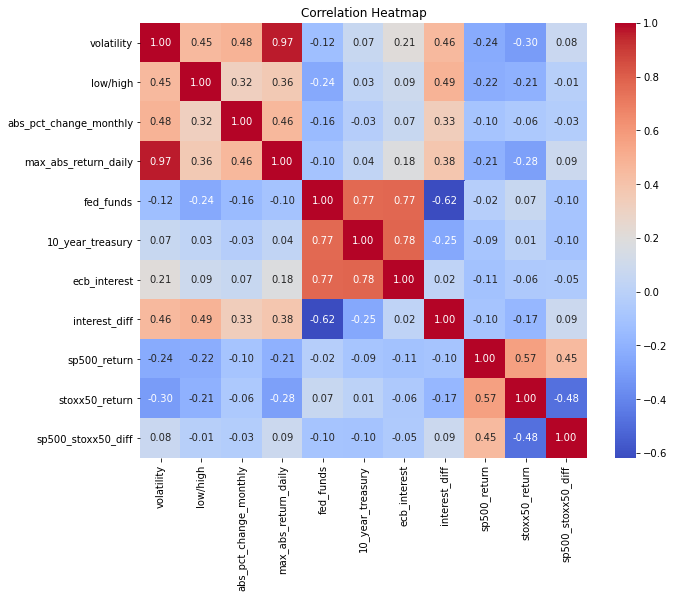

In [7]:
# Generate correlation matrix
correlation_matrix = feature_set.corr()

# Generate heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [8]:
feature_set.dropna(inplace=True)
feature_set.head(5)

,volatility,low/high,abs_pct_change_monthly,max_abs_return_daily,fed_funds,10_year_treasury,ecb_interest,interest_diff,sp500_return,stoxx50_return,sp500_stoxx50_diff
Date,,,,,,,,,,,
2005-02,2.477,0.0,0.012649,0.015078,2.50,4.17,2.0,-0.50,0.018903,0.031585,-0.012681
2005-03,2.774,0.0,0.018919,0.012082,2.63,4.50,2.0,-0.63,-0.019118,0.005031,-0.024148
2005-04,2.162,0.0,0.003386,0.011495,2.79,4.34,2.0,-0.79,-0.020109,-0.016968,-0.003141
2005-05,2.793,1.0,0.047595,0.014019,3.00,4.14,2.0,-1.00,0.029952,0.003226,0.026726
2005-06,3.202,0.0,0.017629,0.014870,3.04,4.00,2.0,-1.04,-0.000143,0.042400,-0.042542


In [9]:
x_data = feature_set.drop(columns=['volatility', 'low/high', 'max_abs_return_daily'], axis=1)
y_data = feature_set['low/high']

x_data.corr()

,abs_pct_change_monthly,fed_funds,10_year_treasury,ecb_interest,interest_diff,sp500_return,stoxx50_return,sp500_stoxx50_diff
abs_pct_change_monthly,1.000000,-0.151775,-0.021272,0.075592,0.329828,-0.099960,-0.064790,-0.035775
fed_funds,-0.151775,1.000000,0.768107,0.768485,-0.619788,-0.012141,0.067023,-0.086015
10_year_treasury,-0.021272,0.768107,1.000000,0.778375,-0.245371,-0.078562,0.009396,-0.093892
ecb_interest,0.075592,0.768485,0.778375,1.000000,0.025850,-0.096040,-0.057179,-0.039902
interest_diff,0.329828,-0.619788,-0.245371,0.025850,1.000000,-0.098821,-0.174837,0.085444
sp500_return,-0.099960,-0.012141,-0.078562,-0.096040,-0.098821,1.000000,0.569648,0.443505
stoxx50_return,-0.064790,0.067023,0.009396,-0.057179,-0.174837,0.569648,1.000000,-0.483994
sp500_stoxx50_diff,-0.035775,-0.086015,-0.093892,-0.039902,0.085444,0.443505,-0.483994,1.000000


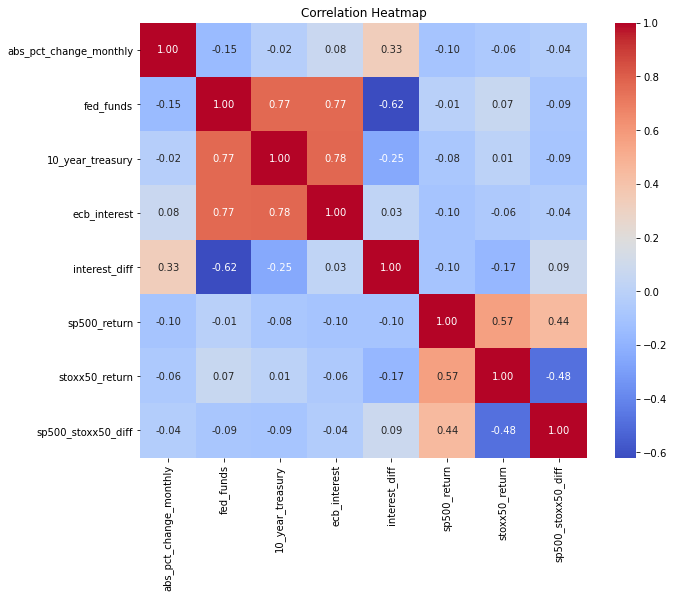

In [11]:
# Generate correlation matrix
correlation_matrix = x_data.corr()

# Generate heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [12]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [17]:
def neural_network(x_train, y_train, x_test, y_test, hidden_layer=3, neurons=12, epochs=10):
    model = Sequential()
    # Add input layer
    model.add(Dense(neurons, input_dim=8, activation='relu'))

    # Add hidden layers
    for _ in range(hidden_layer):
        model.add(Dense(neurons, activation='relu'))

    # Add output layer
    model.add(Dense(1, activation='sigmoid'))

    # Define the optimizer with a custom learning rate
    custom_optimizer = Adam(learning_rate=0.003)
    model.compile(loss='mse', optimizer=custom_optimizer, metrics=['accuracy'])

    current_model = model.fit(x_train, y_train, epochs=epochs, batch_size=10, verbose=0)
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)

    return model, accuracy

In [20]:
# k-folds cross validation function
def k_folds_cross_validation(x_data, y_data, model_func, k=5):
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    fold_size = len(x_data) // k
    accuracies = []
    models = []

    for i in range(k):
        x_train = np.concatenate([x_data[:i * fold_size], x_data[(i + 1) * fold_size:]])
        y_train = np.concatenate([y_data[:i * fold_size], y_data[(i + 1) * fold_size:]])
        x_test = x_data[i * fold_size:(i + 1) * fold_size]
        y_test = y_data[i * fold_size:(i + 1) * fold_size]

        current_model, accuracy = model_func(x_train, y_train, x_test, y_test)

        models.append(current_model)

        accuracies.append(accuracy)

    return accuracies, models

In [22]:
accr, models = k_folds_cross_validation(x_data, y_data, neural_network)
print('Accuracies:', accr)
print('Mean Accuracy:', np.mean(accr))

Accuracies: [0.8260869383811951, 0.5652173757553101, 0.6086956262588501, 0.95652174949646, 0.9130434989929199]
Mean Accuracy: 0.773913037776947


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589 (2.30 KB)

 Trainable params: 589 (2.30 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5342 - loss: 0.2571 - val_accuracy: 0.7174 - val_loss: 0.2184
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.7134 - loss: 0.2076 - val_accuracy: 0.7391 - val_loss: 0.1763
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.7780 - loss: 0.1627 - val_accuracy: 0.8043 - val_loss: 0.1531
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.7724 - loss: 0.1624 - val_accuracy: 0.8043 - val_loss: 0.1427
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.8143 - loss: 0.1502 - val_accuracy: 0.7826 - val_loss: 0.1368
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.7479 - loss: 0.1631 - val_accuracy: 0.8043 - val_loss: 0.1296
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.8086 - loss: 0.1523 - val_accuracy: 0.7609 - val_loss: 0.1255
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.8410 - loss: 0.1416 - val_a

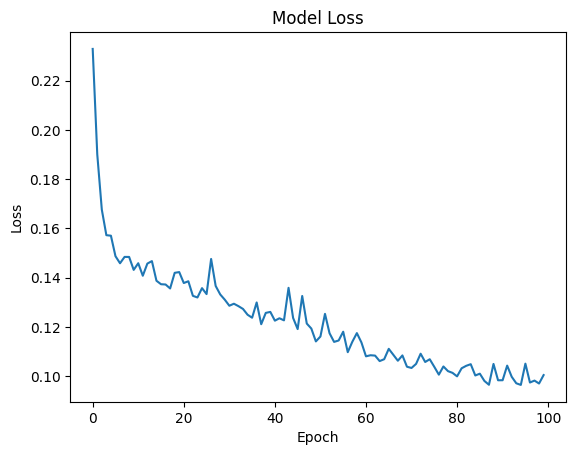

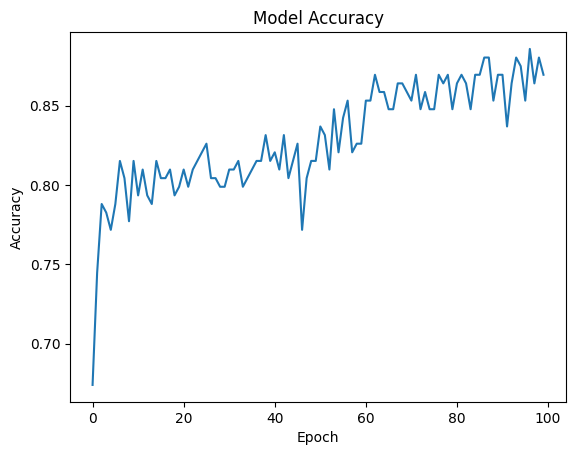

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8279 - loss: 0.1273 
Test Loss: 0.14242306351661682
Test Accuracy: 0.804347813129425


In [19]:
def create_model(x_data, y_data, learning_rate=0.003):
    # Define the model
    model = Sequential()

    # Add input layer
    model.add(Dense(12, input_dim=8, activation='relu'))

    # Add hidden layers
    for _ in range(3):
        model.add(Dense(12, activation='relu'))

    # Add output layer
    model.add(Dense(1, activation='sigmoid'))

    # Define the optimizer with a custom learning rate
    custom_optimizer = Adam(learning_rate=learning_rate)  # Change the learning rate as needed

    # Compile the model with the custom optimizer
    model.compile(optimizer=custom_optimizer, loss='mse', metrics=['accuracy'])
    print(model.summary())
    # Train the model
    history = model.fit(x_train, y_train, epochs=100, batch_size=8, verbose=1, validation_data=(x_test, y_test))

    # Plot the loss function graph
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # Test the model
    loss, accuracy = model.evaluate(x_test, y_test)

    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

In [20]:
predict = pd.DataFrame(model.predict(x_test))
predict.to_excel('results/predict.xlsx', index=False)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [21]:
true = pd.DataFrame(y_test)
true.to_excel('results/true.xlsx', index=False)

In [17]:
0.8260869383811951

0.804347813129425

0.834782600402832